In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

## Loading Dataset

In [2]:
# load all the images
path_cleaned = 'data\\plates\\train\\cleaned\\'
path_dirty = 'data\\plates\\train\\cleaned\\'

data = tf.keras.preprocessing.image_dataset_from_directory(
    'data\\plates\\train',
    labels='inferred',
    label_mode='int',
    class_names=['cleaned', 'dirty'],
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    # validation_split=0.2,
    # subset='training'
)



Found 40 files belonging to 2 classes.


In [3]:
data_iterator = data.as_numpy_iterator()

In [4]:
batch = data_iterator.next()

In [5]:
batch[0].shape

(32, 256, 256, 3)

In [13]:
batch[1]

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0])

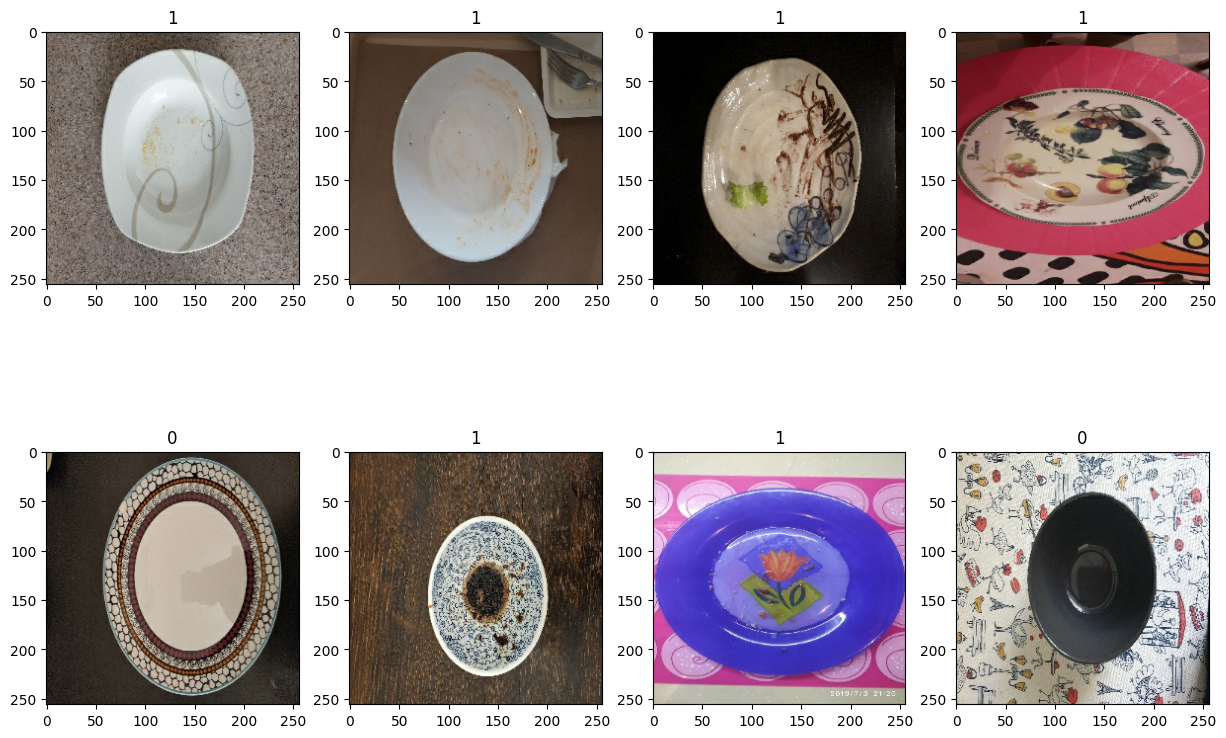

In [6]:
# plot the images
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))  # change to nrows=2, ncols=4
for idx, img in enumerate(batch[0][:8]):  # change the slice to :8
    row = idx // 4  # calculate row index
    col = idx % 4  # calculate column index
    ax[row, col].imshow(img.astype(int))
    ax[row, col].title.set_text(batch[1][idx])

## Prepocessing Data

In [15]:
# Preprocessing
datagen = ImageDataGenerator(rescale=1./255)
train_data = datagen.flow_from_directory('data\\plates\\train',
                                         target_size=(256, 256),
                                         batch_size=32,
                                         class_mode='binary',
                                         color_mode='rgb')

Found 40 images belonging to 2 classes.


## Model training

In [16]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
# Train the model
history = model.fit(train_data, epochs=10)

Epoch 1/10
2/2 [==============================] - 6s 937ms/step - loss: 6.3647 - accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 0s 72ms/step - loss: 1.8072 - accuracy: 0.5000
Epoch 3/10
2/2 [==============================] - 0s 65ms/step - loss: 0.7136 - accuracy: 0.6000
Epoch 4/10
2/2 [==============================] - 0s 85ms/step - loss: 0.6662 - accuracy: 0.6750
Epoch 5/10
2/2 [==============================] - 0s 73ms/step - loss: 0.6483 - accuracy: 0.6000
Epoch 6/10
2/2 [==============================] - 0s 16ms/step - loss: 0.5783 - accuracy: 0.6750
Epoch 7/10
2/2 [==============================] - 0s 29ms/step - loss: 0.6198 - accuracy: 0.5250
Epoch 8/10
2/2 [==============================] - 0s 58ms/step - loss: 0.4450 - accuracy: 0.9000
Epoch 9/10
2/2 [==============================] - 0s 77ms/step - loss: 0.3901 - accuracy: 0.9250
Epoch 10/10
2/2 [==============================] - 0s 67ms/step - loss: 0.4231 - accuracy: 0.7750


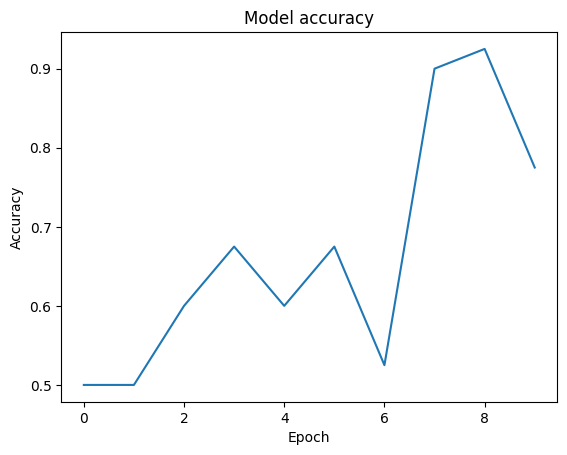

In [19]:
# Plot the training history
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# Save the model
model.save('model.h5')

In [ ]:
# Load the model
model = tf.keras.models.load_model('model.h5')

## Creating Submission